In [108]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn # torch.nn contains all of PT building blocks for Neural Networks
import matplotlib.pyplot as plt
import sklearn

DEVICE = "cuda" if torch.cuda.is_available() \
    else "mps" if torch.backends.mps.is_available() \
    else "cpu"

RANDOM_SEED = 42

torch.set_default_device(DEVICE)
torch.manual_seed(RANDOM_SEED)
print(f"Seed: {RANDOM_SEED}", f"Device: {DEVICE}", f"PyTorch: {torch.__version__}")

Seed: 42 Device: mps PyTorch: 2.0.1


# PyTorch Classification

Main types of classification:

* Binary Classification = X ->1 | 2 ?
* Multi-class Classification = X -> 1 | 2 | 3 ?
* Multi-label Classification = X -> {?1, ?2, ?3, ..., ?N}

## Architecture of a classification model

Hyperparameters:

* Input layer shape (`in_features`) -> i.e. number of features (and shape)
* Hidden layer(s) -> 1 to how many you want
* Neurons per hidden layer -> problem specific, usually 10 to 512
* Output layer shape (`out_features`) -> BC: 1 - MC: 1 per class
* Hidden layer activation: usually ReLU but many possibilities
* Output activation -> BC: Sigmoid `torch.sigmoid` - MC: Softmax `torch.softmax`
* Loss function -> BC: Binary Cross-Entropy `torch.nn.BCELoss` - MC: Cross-Entropy `torch.nn.CrossEntropyLoss`
* Optimizer: SGD, Adam, or `torch.optim` for more options

## Creating synthetic classification data

In [109]:
# Create synthetic data

from sklearn.datasets import make_circles

N_SAMPLES = 1000

X, y = make_circles(N_SAMPLES,
                    noise=0.03,
                    random_state=RANDOM_SEED)

# Turn data into tensors

X = torch.from_numpy(X).type(torch.float32).to(DEVICE)
y = torch.from_numpy(y).type(torch.float32).to(DEVICE)

X[:5], X.shape, y[:5], y.shape

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]], device='mps:0'),
 torch.Size([1000, 2]),
 tensor([1., 1., 1., 1., 0.], device='mps:0'),
 torch.Size([1000]))

In [110]:
# Make a DataFrame of circle data

circles = pd.DataFrame({"X1" : X.cpu().numpy()[:, 0], 
                        "X2" : X.cpu().numpy()[:, 1], 
                        "label": y.cpu().numpy()})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1.0
1,-0.756159,0.153259,1.0
2,-0.815392,0.173282,1.0
3,-0.393731,0.692883,1.0
4,0.442208,-0.896723,0.0
5,-0.479646,0.676435,1.0
6,-0.013648,0.803349,1.0
7,0.771513,0.147760,1.0
8,-0.169322,-0.793456,1.0
9,-0.121486,1.021509,0.0


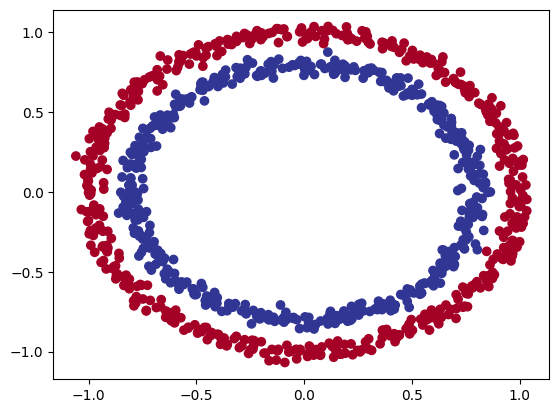

In [111]:
# Visualize data set

plt.scatter(x=X.cpu().numpy()[:, 0],
            y=X.cpu().numpy()[:, 1],
            c=y.cpu().numpy(),
            cmap=plt.cm.RdYlBu)

In [112]:
# Split into training and test sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

len(X_train), len(X_test)

(800, 200)

## Building a Classification Model with PyTorch

In [113]:
# Define classifier with nn.Sequential API

model_0_sequential = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
)

model_0_sequential.state_dict()

# Define classifier with Object-Oriented API

class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_layer = nn.Linear(in_features=2, out_features=5)
        self.hidden_layer = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        return self.hidden_layer(self.input_layer(x))

model_0 = CircleModelV0()

model_0.state_dict(), model_0_sequential.state_dict()

(OrderedDict([('input_layer.weight',
               tensor([[ 0.7042,  0.1246],
                       [ 0.5297, -0.1442],
                       [ 0.2957, -0.2031],
                       [-0.3933,  0.3799],
                       [-0.0520,  0.5525]], device='mps:0')),
              ('input_layer.bias',
               tensor([-0.6695, -0.2138,  0.5031,  0.2058, -0.6160], device='mps:0')),
              ('hidden_layer.weight',
               tensor([[ 0.1916,  0.2478,  0.1889, -0.3741,  0.0156]], device='mps:0')),
              ('hidden_layer.bias', tensor([0.1349], device='mps:0'))]),
 OrderedDict([('0.weight',
               tensor([[ 0.4486,  0.1246],
                       [ 0.0821,  0.3806],
                       [-0.2272, -0.0623],
                       [ 0.2476, -0.7065],
                       [-0.1290, -0.4538]], device='mps:0')),
              ('0.bias',
               tensor([-0.6137, -0.2447,  0.0219, -0.3876,  0.4713], device='mps:0')),
              ('1.weight',
       

In [114]:
# Make predictions

with torch.inference_mode():
    untrained_preds = model_0(X_test)

untrained_preds[:10].squeeze().round() == y_test[:10]

tensor([False,  True, False,  True, False, False,  True,  True, False,  True],
       device='mps:0')

In [115]:
# Setup Loss and Optimizer


bce_loss_fn = nn.BCELoss() # requires inputs to have gone through the sigmoid activation function prior to input

bce_loss_with_logits_equivalent_fn = nn.Sequential(
    nn.Sigmoid(),
    nn.BCELoss()
)

loss_fn = nn.BCEWithLogitsLoss() # has the Sigmoid activation function built-in
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

loss_fn, optimizer

(BCEWithLogitsLoss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     lr: 0.1
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

## Turning Logits into Probabilities and Evaluating Accuracy

In [116]:
# We must go from:
# raw logits [-inf, +inf] -> prediction probabilities [0, 1] -> prediction labels {A, B, C}
# We can convert into probabilities using sigmoid (BC) and softmax (MC
# We can convert into labels by either rounding probabilities or taking the argmax

with torch.inference_mode():
    y_logits = model_0(X_test)[:5]
    
y_logits

tensor([[-0.3392],
        [-0.2072],
        [-0.3093],
        [-0.3492],
        [ 0.2872]], device='mps:0')

In [117]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4160],
        [0.4484],
        [0.4233],
        [0.4136],
        [0.5713]], device='mps:0')

In [118]:
y_pred = y_pred_probs.round()
y_pred

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [1.]], device='mps:0')

In [119]:
with torch.inference_mode():
    y_pred_labels = model_0.forward(X_test)[:5].sigmoid().round()

y_pred_labels

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [1.]], device='mps:0')

In [120]:
# Setup Evaluation Metric

def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = 100 * correct / len(y_pred)
    return acc

## Training and Testing a Classification Model

In [121]:
# Train model

torch.manual_seed(RANDOM_SEED)

EPOCHS = 2000
LOG_INTERVAL = 100

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=32),
    nn.ReLU(),
    nn.Linear(in_features=32, out_features=1)
)

def get_labels(x: torch.Tensor) -> torch.Tensor:
        return model_0(x).squeeze().sigmoid().round()

loss_fn = nn.BCEWithLogitsLoss() # has the Sigmoid activation function built-in
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

for epoch in range(EPOCHS):
    ### Training
    model_0.train()

    y_logits = model_0.forward(X_train).squeeze()

    loss = loss_fn(y_logits, y_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    ### Testing
    model_0.eval()
    
    if epoch % LOG_INTERVAL == 0:
        with torch.inference_mode():
            train_acc = accuracy_fn(get_labels(X_train), y_train)
            test_acc = accuracy_fn(get_labels(X_test), y_test)
    
            print(f"Epoch: {epoch} | Train Acc: {train_acc} | Test Acc: {test_acc}")

Epoch: 0 | Train Acc: 50.5 | Test Acc: 51.0
Epoch: 100 | Train Acc: 54.375 | Test Acc: 57.5
Epoch: 200 | Train Acc: 69.875 | Test Acc: 67.0
Epoch: 300 | Train Acc: 85.5 | Test Acc: 78.5
Epoch: 400 | Train Acc: 93.25 | Test Acc: 90.0
Epoch: 500 | Train Acc: 96.25 | Test Acc: 95.0
Epoch: 600 | Train Acc: 97.125 | Test Acc: 96.5
Epoch: 700 | Train Acc: 98.125 | Test Acc: 96.5
Epoch: 800 | Train Acc: 98.5 | Test Acc: 96.5
Epoch: 900 | Train Acc: 98.75 | Test Acc: 97.0
Epoch: 1000 | Train Acc: 99.0 | Test Acc: 98.0
Epoch: 1100 | Train Acc: 99.375 | Test Acc: 99.0
Epoch: 1200 | Train Acc: 99.75 | Test Acc: 99.0
Epoch: 1300 | Train Acc: 99.75 | Test Acc: 99.0
Epoch: 1400 | Train Acc: 99.75 | Test Acc: 99.0
Epoch: 1500 | Train Acc: 99.75 | Test Acc: 99.0
Epoch: 1600 | Train Acc: 99.75 | Test Acc: 99.0
Epoch: 1700 | Train Acc: 99.75 | Test Acc: 99.0
Epoch: 1800 | Train Acc: 99.875 | Test Acc: 99.0
Epoch: 1900 | Train Acc: 100.0 | Test Acc: 99.0


In [122]:
get_labels(X_test).eq(y_test).unsqueeze(-1)

tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True

In [123]:
# Plot decision boundary


def plot_decision_boundary(model: torch.nn.Module, X_in: torch.Tensor, y_in: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X_in.to("cpu"), y_in.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    model.to(DEVICE)

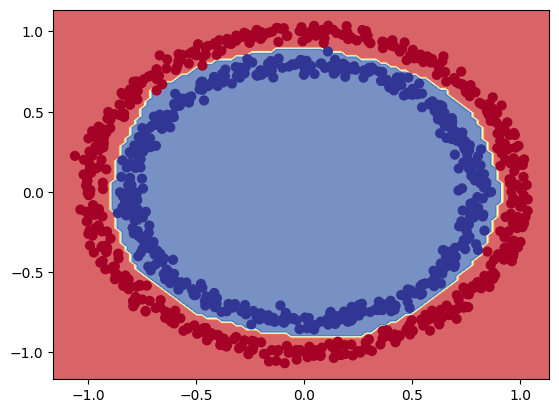

In [124]:
plot_decision_boundary(model_0, X, y)

## Improving Models

* Add more layers
* Add more hidden units
* Fit for longer
* Change activation functions
* Change the learning rate or other optim-loss hyperparameters
* Change the optim-loss

These options are all from a **model** perspective, because they deal directly with the model. The other option is to improve data.

In [125]:
torch.manual_seed(RANDOM_SEED)

EPOCHS = 2000
LOG_INTERVAL = 100

model_1 = nn.Sequential(
    nn.Linear(in_features=2, out_features=10),
    nn.ReLU(),
    nn.Linear(in_features=10, out_features=10),
    nn.ReLU(),
    nn.Linear(in_features=10, out_features=1)
)



class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        z = self.layer_1(x).relu()
        z = self.layer_2(x).relu()
        z = self.layer_3(x).sigmoid()
        return z

model_2 = CircleModelV1()

model_2

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

## Non-linear Activation Functions

In [126]:
A = torch.arange(-10, 10, step=1, dtype=torch.float32)
A.dtype

torch.float32

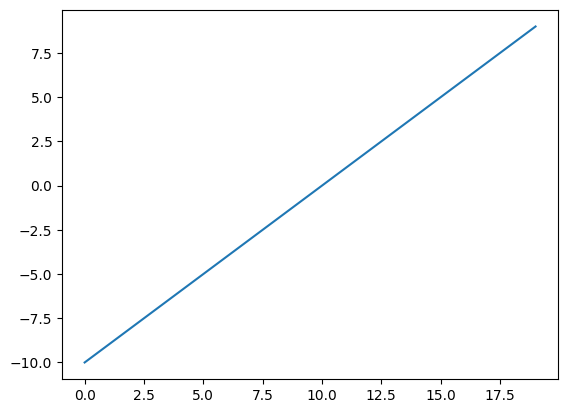

In [127]:
plt.plot(A.cpu())

In [128]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.], device='mps:0')

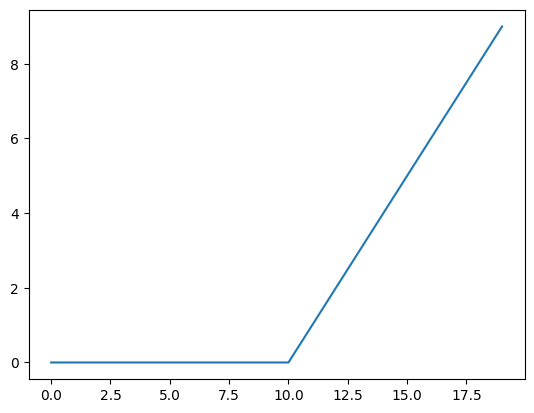

In [129]:
plt.plot(relu(A).cpu())

In [130]:
def sigmoid(x: torch.Tensor) -> torch.Tensor:
    return 1 / (1 + torch.exp(-x))

sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01], device='mps:0')

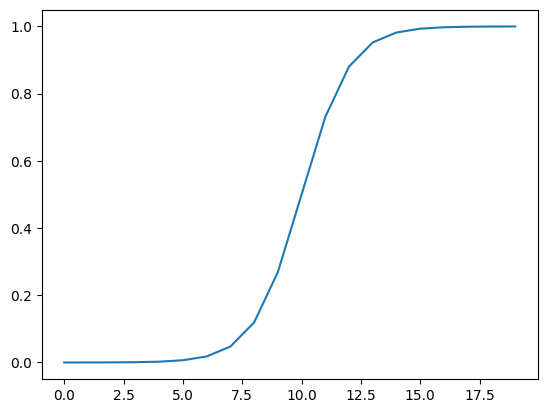

In [131]:
plt.plot(sigmoid(A).cpu())

## Multi-class Classification

In [132]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

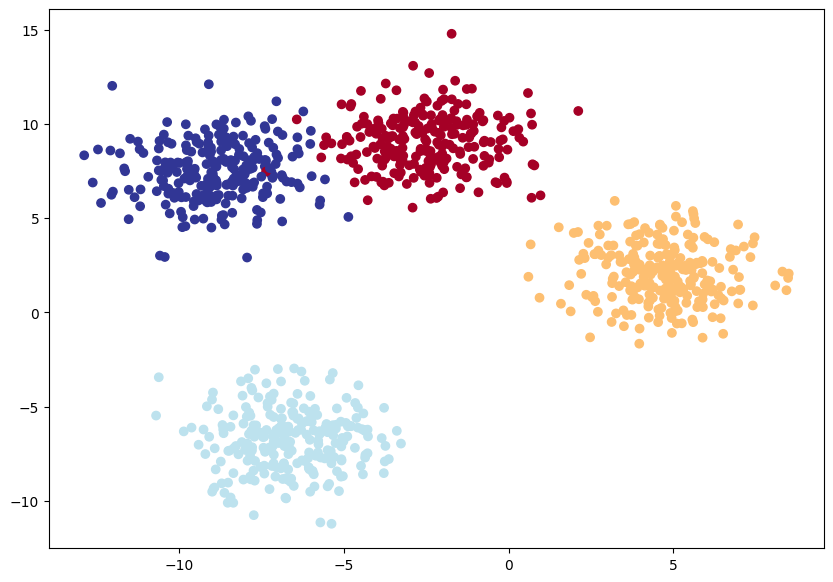

In [133]:
# 0. Set hyperparams for data creation

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors

X_blob = torch.from_numpy(X_blob).type(torch.float).to(DEVICE)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor).to(DEVICE)

# 3. Split into train and test

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2, 
                                                                        random_state=RANDOM_SEED)


# 4. Plot data
plt.figure(figsize=(10, 7))

plt.scatter(X_blob.cpu()[:, 0], X_blob.cpu()[:, 1], c=y_blob.cpu(), cmap=plt.cm.RdYlBu)

## Multi-class Classification Models with PyTorch

We need to convert model raw output (logits) to prediction probabilities and then to prediction labels

Logits -> Pred probs -> Pred labels

In [134]:
class BlobModel(nn.Module):
    def __init__(self,
                 input_features, 
                 output_features,
                 hidden_units=8):
        """
        Init multi-class classification
        """
        super().__init__()
        self.input_features = input_features
        self.output_features = output_features
        self.hidden_units = hidden_units
        
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack.forward(x)
        

X_blob_train.shape, y_blob_train[:5]

(torch.Size([800, 2]), tensor([1, 0, 2, 2, 0], device='mps:0'))

In [135]:
y_blob.unique()

tensor([0, 1, 2, 3], device='mps:0')

In [136]:
model_4 = BlobModel(input_features=2, output_features=4, hidden_units=8).to(DEVICE)

In [137]:
# Create multi-class classification loss and optim

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.01)
with torch.inference_mode():
    y_logits = model_4(X_blob_test)
    y_probabilities = y_logits.softmax(dim=1)
    y_preds = y_probabilities.argmax(dim=1).type(torch.float)
                

y_preds, y_blob_test

(tensor([3., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0., 3., 0., 0., 0., 1., 1., 2.,
         1., 1., 1., 0., 2., 2., 2., 1., 1., 0., 3., 0., 1., 3., 2., 1., 3., 1.,
         2., 1., 0., 2., 0., 1., 1., 1., 0., 1., 3., 0., 0., 1., 2., 1., 2., 2.,
         1., 1., 2., 2., 1., 2., 1., 0., 1., 1., 2., 0., 0., 1., 1., 0., 0., 1.,
         1., 1., 1., 1., 1., 1., 1., 2., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 2., 1., 1., 1., 2., 0., 1., 1., 0., 1., 1., 0., 1., 1., 2., 1.,
         1., 2., 2., 2., 0., 2., 1., 1., 0., 0., 2., 1., 1., 1., 0., 2., 2., 0.,
         0., 0., 1., 1., 3., 2., 1., 2., 0., 1., 0., 0., 3., 2., 3., 0., 2., 1.,
         1., 1., 0., 1., 1., 1., 2., 3., 1., 1., 1., 0., 1., 1., 1., 3., 1., 0.,
         1., 2., 0., 1., 2., 1., 2., 2., 2., 0., 1., 2., 3., 3., 2., 2., 1., 3.,
         1., 2., 2., 3., 2., 1., 1., 3., 2., 1., 0., 1., 2., 1., 1., 0., 1., 2.,
         1., 3.], device='mps:0'),
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0,

In [138]:
y_probabilities.sum(dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

## Training a Multi-Class Classifier

In [139]:
### Model definition

class BlobModel(nn.Module):
    def __init__(self,
                 input_features, 
                 output_features,
                 hidden_units=8):
        """
        Init multi-class classification
        """
        super().__init__()
        self.input_features = input_features
        self.output_features = output_features
        self.hidden_units = hidden_units
        
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

### Experiment Set-up

EPOCHS = 1000
LOG_INTERVAL = 100
torch.manual_seed(RANDOM_SEED)

model_4 = BlobModel(2, 4)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.01)

X_blob_train, y_blob_train = X_blob_train.to(DEVICE), y_blob_train.to(DEVICE)
X_blob_test, y_blob_test = X_blob_test.to(DEVICE), y_blob_test.to(DEVICE)


def accuracy(input: torch.Tensor, target: torch.Tensor) -> float:
    total = target.size(dim=0)
    correct = target.eq(input).cpu().apply_(lambda b: 1 if b else 0).sum().item()
    return correct / total

for epoch in range(EPOCHS):
    ### Training
    model_4.train()

    y_logits = model_4(X_blob_train)
    
    y_pred = y_logits.softmax(dim=1).argmax(dim=1)
    
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy(y_pred, y_blob_train)
    
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    ### Testing
    model_4.eval()

    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_pred = test_logits.softmax(dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy(test_pred, y_blob_test)
        

    
    if epoch % LOG_INTERVAL == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.4f} | Acc: {acc:-2f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:-2f}')
    

Epoch: 0 | Loss: 1.2532 | Acc: 0.487500 | Test Loss: 1.1738 | Test Acc: 0.550000
Epoch: 100 | Loss: 0.7321 | Acc: 0.695000 | Test Loss: 0.6791 | Test Acc: 0.755000
Epoch: 200 | Loss: 0.5247 | Acc: 0.953750 | Test Loss: 0.4776 | Test Acc: 0.965000
Epoch: 300 | Loss: 0.3015 | Acc: 0.986250 | Test Loss: 0.2688 | Test Acc: 0.990000
Epoch: 400 | Loss: 0.1446 | Acc: 0.991250 | Test Loss: 0.1293 | Test Acc: 0.995000
Epoch: 500 | Loss: 0.0879 | Acc: 0.991250 | Test Loss: 0.0774 | Test Acc: 0.995000
Epoch: 600 | Loss: 0.0652 | Acc: 0.991250 | Test Loss: 0.0558 | Test Acc: 0.995000
Epoch: 700 | Loss: 0.0536 | Acc: 0.991250 | Test Loss: 0.0445 | Test Acc: 0.995000
Epoch: 800 | Loss: 0.0468 | Acc: 0.991250 | Test Loss: 0.0377 | Test Acc: 0.995000
Epoch: 900 | Loss: 0.0424 | Acc: 0.991250 | Test Loss: 0.0333 | Test Acc: 0.995000


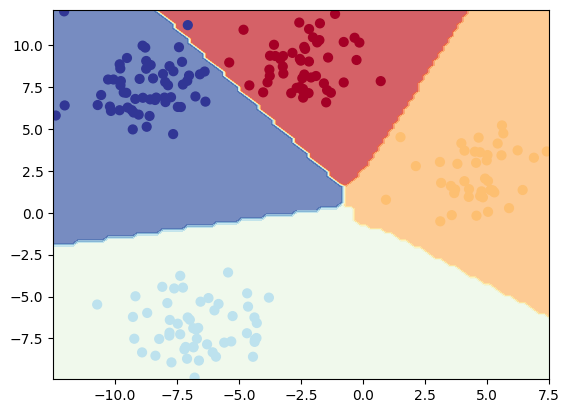

In [140]:
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## Metrics: evaluating predictions with a PyTorch multi-class model

(Read "Beyond Accuracy... Precision and Recall" on TDS)

### Accuracy
$$\frac{correct}{total}$$ `torchmetrics.Accuracy` / `sklearn.metrics.accuracy_score`

### Precision 
$$\frac{tp}{tp + fp}$$ `torchmetrics.Precision` / `sklearn.metrics.precision_score`

### Recall
$$tp / (tp + fn)$$ `torchmetrics.Recall` / `sklearn.metrics.recall_score`

### F1-Score
$$2 * \frac{precision * recall}{precision + recall}$$ `torchmetrics.F1Score` / `sklearn.metrics.f1_score

### Confusion Matrix
`torchmetrics.ConfusionMatrix`

### Classification Report
`sklearn.metrics.classification_report` -> puts together all these metrics

### Confusion Matrix

There is a trade-off between precision and recall: higher precision leads to less false positives, higher recall leads to less false negatives. If we are not biased towards one or the other, we can use the F1-score, which combines both.

In [141]:
# Make predictions

model_4.eval()

with torch.inference_mode():
    y_logits = model_4(X_blob_test)
    y_pred = y_logits.argmax(dim=1)
    


In [142]:
from torchmetrics import Accuracy, Precision, Recall, F1Score, ConfusionMatrix

In [143]:
accuracy_fn = Accuracy('multiclass', num_classes = 4)

accuracy_fn(y_pred, y_blob_test)

tensor(0.9950, device='mps:0')